# VQE with GBS on Strawberryfields

This tutorial introduces how to implement a variational quantum eigensolver (VQE) with Gaussian Bosonic Sampling on Strawberryfields platform which simulates bosonic modular processes. Qiskit provides another way to implement VQE on quantum circuits.

VQE makes use of the variational method, based on the variational principle, to find approximations to the lowest energy eigenstate or ground state, and some excited states. This allows calculating approximate wavefunctions such as molecular orbitals.

In [1]:
#@title Install & import the necessary packages
%%capture
!pip install strawberryfields
!pip install tensorflow
!pip install pylatexenc

In [2]:
import numpy as np
import strawberryfields as sf
from strawberryfields.ops import *
from strawberryfields.utils import operation
import tensorflow as tf
from matplotlib import pyplot as plt

## Strawberryfields platform

Instead of a discrete qubit model in quantum computing, Strawberryfields utilizes a continuous-variable (CV) model that allows simulation of bosonic systems (light is intrinsically continuous). The associated architecture with controllable gates realizes the Gaussian boson sampling (GBS) algorithm that can be applied to different fields such as graph problems, machine learning, chemistry...

In preparing the known architecture in Strawberryfields, the main steps are:
1. sf.Program(number of modes) is declared
2. An engine backend is specified. Here, we are using the TensorFlow backend for later optimization.
3. Define quantum circuit/program with operations in sf.ops.
4. Run engine, extract properties from results.state.

A sample program is given below:

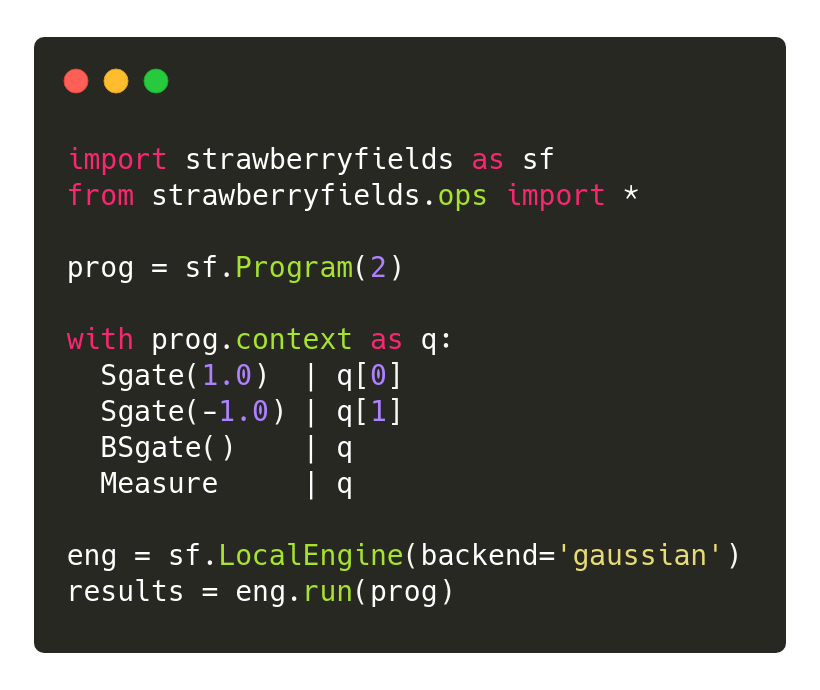

## Bose-Hubbard Hamiltonian

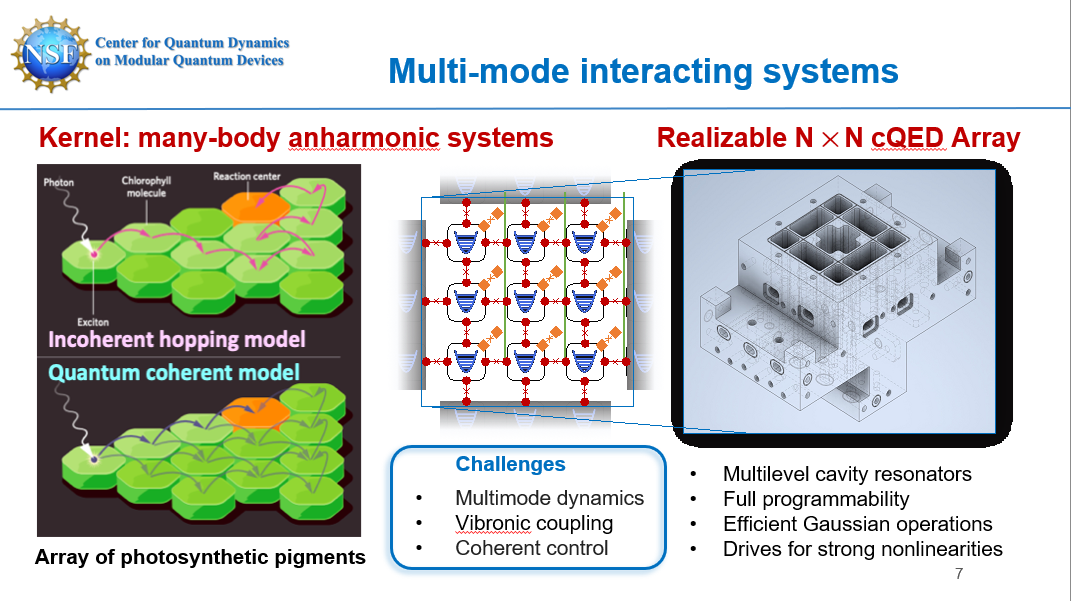

The Bose-Hubbard model offers one of the most simple ways to get insight into how the interactions between electrons can give rise to insulating, magnetic, and even novel superconducting effects in a solid. It was written down in the early 1960's and initially applied to understanding the behavior of the transition metal monoxides (FeO, NiO, CoO), compounds which are
antiferromagnetic insulators, yet had been predicted to be metallic by methods which treat strong interactions less carefully. Despite its
simplicity, its exhibits behavior relevant to many of the most subtle and beautiful properties of solid state systems. [Source: hubbard7.pdf file]

### Simulation

For a pair of two adjacent nodes (corresponding to two qumodes) represented by the adjacency matrix $A = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}$, the Bose-Hubbard Hamiltonian with on-site interactions is given by $$H = J \sum_{i, j} A_{ij}\hat{a}_i^\dagger \hat{a}_j + \frac{1}{2}U \sum_{i} \hat{n}_i(\hat{n}_i-1) = J(\hat{a}_1^\dagger \hat{a}_2 + \hat{a}_2^\dagger \hat{a}_1) + \frac{1}{2}U (\hat{n}_1^2-\hat{n}_1+\hat{n}_2^2-\hat{n}_2)$$ with $J$ being the transfer integral of the boson between nodes and $U$ the on-site interaction potential. We can now write $$e^{-iHt} = \left[\text{exp}\left(-i\frac{Jt}{k}(\hat{a}_1^\dagger\hat{a}_2+\hat{a}_2^\dagger\hat{a}_1)\right)\text{exp}\left(-i\frac{Ut}{2k}\hat{n}_1^2\right)\text{exp}\left(-i\frac{Ut}{2k}\hat{n}_2^2\right)\text{exp}\left(i\frac{Ut}{2k}\hat{n}_1\right)\text{exp}\left(i\frac{Ut}{2k}\hat{n}_2\right)\right]^k + O\left(\frac{t^2}{k}\right) = [BS(\theta,\phi)\left(K(r)R(-r)\otimes K(r)R(-r)\right)]^k + O\left(\frac{t^2}{k}\right)$$ with $\theta=-Jt/k,\phi=\pi/2$, and $r=-Ut/2k$.

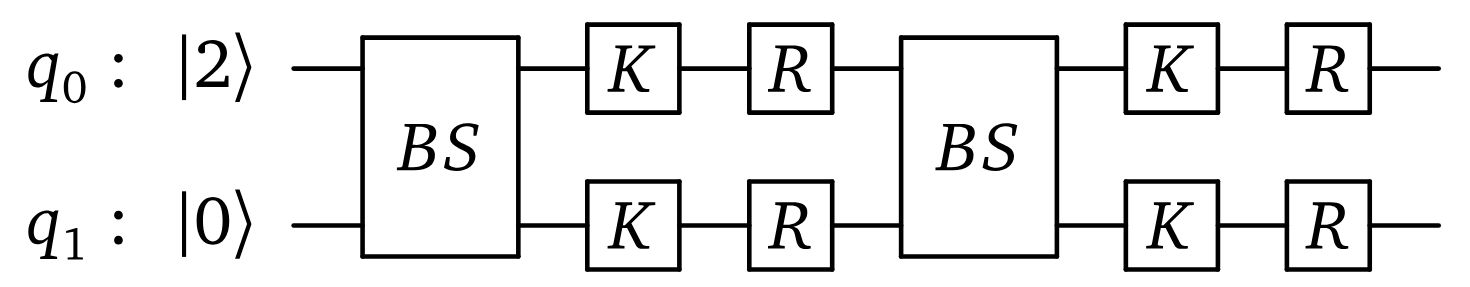

#### C.1 Bose-Hubbard Hamiltonian Global Parameters

In [3]:
# set the Hamiltonian parameters
J = 1 # hopping transition
U = 1.5 # on-site interaction
k = 20 # Lie product decomposition ,→ terms, or depth

t = 1.086 # timestep
theta = -J*t/k
r = -U*t/(2*k)
ket = np.zeros([10]*2, dtype=np.complex64)
ket[2,0] = 1.0 + 0.0j

#### C.2 Evolving Bose-Hubbard Hamiltonian

In [4]:
# Declare Program
prog = sf.Program(2)
# Define the Quantum Circuit
with prog.context as q:
  # prepare the initial state
  Ket(ket) | q

  # Two node tight-binding
  # Hamiltonian simulation

  for i in range(k):
    BSgate(theta, np.pi/2) | (q[0], q[1])
    Kgate(r) | q[0]
    Rgate(-r) | q[0]
    Kgate(r) | q[1]
    Rgate(-r) | q[1]
  # end circuit

# run the engine
eng = sf.Engine('fock', backend_options={"cutoff_dim": 10})
state = eng.run(prog).state

# the output state probabilities
print(state.fock_prob([0,2]))
print(state.fock_prob([1,1]))
print(state.fock_prob([2,0]))

0.5224012457200216
0.235652876856725
0.2419458774232605


In order to calculate energy $E=\frac{\langle\psi|H|\psi\rangle}{\langle\psi|\psi\rangle}$ of output statevector $|\psi\rangle$, we need to compute the expectation value of $H = J(\hat{a}_1^\dagger \hat{a}_2 + \hat{a}_2^\dagger \hat{a}_1) + \frac{1}{2}U (\hat{n}_1^2-\hat{n}_1+\hat{n}_2^2-\hat{n}_2) = \hat{J} + \frac{1}{2}\hat{U}$.

Now note that, with the notation $|\psi\rangle = \sum_i^{10}\sum_j^{10} c_{i,j} |i,j\rangle$,


*   $\langle\psi|\hat{a}_1^\dagger\hat{a}_2|\psi\rangle = \left(\sum_i^{10}\sum_j^{10} c_{i,j}^* \langle i,j|\right)\left(\sum_{i'}^{10}\sum_{j'}^{10} c_{i',j'} \sqrt{j'(i'+1)} |i'+1,j'-1\rangle\right) = \sum_i^{10}\sum_j^{10} c_{i,j}^* \sqrt{i(j+1)} c_{i-1,j+1}$. Similarly, $$\langle\psi|\hat{J}|\psi\rangle = \sum_i^{10}\sum_j^{10} c_{i,j}^* \left(\sqrt{i(j+1)} c_{i-1,j+1}+\sqrt{j(i+1)} c_{i+1,j-1}\right)$$
*   On the other hand, $\langle\psi|\hat{n}_1|\psi\rangle = \left(\sum_i^{10}\sum_j^{10} c_{i,j}^* \langle i,j|\right)\left(\sum_{i'}^{10}\sum_{j'}^{10} c_{i',j'} i |i',j'\rangle\right) = \sum_i^{10}\sum_j^{10} i |c_{i,j}|^2$ and $\langle\psi|\hat{n}_1^2|\psi\rangle = \sum_i^{10}\sum_j^{10} i^2 |c_{i,j}|^2$. Hence, $$\langle \psi|\frac{1}{2}\hat{U}|\psi\rangle = \frac{1}{2}\sum_i^{10}\sum_j^{10} |c_{i,j}|^2 (i^2+j^2-i-j) $$

The functions *hopping_term* and *on_site* below calculates the expectation values of $\hat{J}$ and $\frac{1}{2}\hat{U}$ as described.

#### C.3 Calculating Energy of Evolved State

In [5]:
Fock_cut = 10
# hopping term and on-site calculation
def hopping_term(statevec):
    svc = np.conj(statevec)
    hop = 0
    for i in range(Fock_cut):
        if i == 0:
            for j in range(1,Fock_cut):
                hop += (svc[i,j]*np.sqrt((i+1)*j)*statevec[i+1,j-1])
        else:
            for j in range(Fock_cut-1):
                hop += (svc[i,j]*np.sqrt(i*(j+1))*statevec[i-1,j+1])
            if i < Fock_cut-1:
                for x in range(1,Fock_cut):
                    hop += (svc[i,x]*np.sqrt((i+1)*x)*statevec[i+1,x-1])
    return np.abs(hop*J)

def on_site(statevec):
    on_site = 0
    for i in range(Fock_cut):
        for j in range(Fock_cut):
            on_site += np.abs(statevec[i,j])*(i**2+j**2-i-j)
    return np.abs(on_site*U/2)

sket = state.ket()
inner_prod = np.abs(np.vdot(sket,sket))
energy = (hopping_term(sket)+on_site(sket))/inner_prod
print(energy)

2.1356427750453006


## Set up global parameters
These global parameters apply to the rest of the tutorial.

- cutoff: number of levels per bosonic mode, i.e., Fock dimension truncation.
- depth: number of repeating layers in the circuit
- reps: number of optimization steps
- lr: learning rate for tf optimizers, shows how much the optimized parameters move along the gradient direction
- std: standard deviations used for normal distribution.
- set_seed: ensure reproducibility over runs.

#### C.4 Setting up for performing VQE

In [6]:
cutoff = 6
depth = 4
reps = 50
lr = 0.1
std = 0.01
active_std = 0.001
passive_std = 0.1
# Global seed to ensure reproducibility over runs
tf.random.set_seed(42)

In [7]:
#@title Plotting Functions
# Define function to plot fidelity vs opt step
def plot_fid(fid_progress):

    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.sans-serif"] = ["Computer Modern Roman"]
    plt.style.use("default")

    plt.plot(fid_progress)
    plt.ylabel("Fidelity")
    plt.xlabel("Step")

# Define function to plot energy vs opt step
def plot_energy(E_progress):

    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.sans-serif"] = ["Computer Modern Roman"]
    plt.style.use("default")

    plt.plot(E_progress)
    plt.ylabel("Energy")
    plt.xlabel("Step")

## Optimize to coherent state from vacuum via displacement gate

The coherent state $|\alpha\rangle$ is defined as the eigenstate corresponding to eigenvalue $\alpha$ of the annihilation operator (lowering the quantum state level by 1) $\hat{a}$: $$\hat{a}|\alpha\rangle=\alpha|\alpha\rangle$$

Given the target statevector $|\psi_t\rangle$ in Fock basis, the Uhlmann's fidelity (or overlap) between the pure output state $|\psi\rangle$ and pure target state is measured by $F=|\langle \psi|\psi_t\rangle|^2$. By Cauchy-Schwarz inequality, $F\leq 1$. Here, we run an optimization for *hyperparameter* $\Theta$ containing all parameters involved in each operation/gate in each layer of the circuit so as to maximize the fidelity $F$ near 1 as possible.

#### C.5 Optimizing to coherent state via displacement gate

In [8]:
# initialize engine and program objects
eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": 6})
circuit = sf.Program(1)

tf_r = tf.Variable(tf.random.normal(shape=[], stddev=0.001)) # center = .. to define center
tf_phi = tf.Variable(tf.random.normal(shape=[], stddev=0.001))

r, phi = circuit.params("r", "phi")

# define circuit
with circuit.context as q:
    Dgate(r, phi) | q[0]

In [9]:
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
steps = 100
best_fid = 0
# target coherent state in Fock basis
alpha = 0.70710678118+0.70710678118j
coh = lambda a, dim: np.array([np.exp(-0.5 * np.abs(a) ** 2) * (a) ** n / np.sqrt(np.math.factorial(n)) for n in range(dim)])
target_statevec = coh(alpha,cutoff)
# opt starts here
for step in range(steps):

    # reset the engine if it has already been executed
    if eng.run_progs:
        eng.reset()

    with tf.GradientTape() as tape:
        # execute the engine
        results = eng.run(circuit, args={"r": tf_r, "phi": tf_phi})
        # get the probability of fock state |1>
        fid = results.state.fidelity_coherent([alpha])
        # save ket vector
        ket = results.state.ket()
        # negative sign to maximize prob
        loss = 1-tf.sqrt(fid)

    gradients = tape.gradient(loss, [tf_r, tf_phi])
    opt.apply_gradients(zip(gradients, [tf_r, tf_phi]))
    print("Fidelity at step {}: {}".format(step, fid))
    if fid > best_fid:
        best_fid = fid
        best_r = tf_r
        best_phi = tf_phi
        learnt_state = ket.numpy()

    if step == 0:
        first_step_state = ket.numpy()

print(best_fid.numpy(), best_r.numpy(), best_phi.numpy())

<ipython-input-9-31546ed7b68d>:6: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`


Fidelity at step 0: 0.3680497407913208
Fidelity at step 1: 0.425284743309021
Fidelity at step 2: 0.49049654603004456
Fidelity at step 3: 0.5645244717597961
Fidelity at step 4: 0.6462993025779724
Fidelity at step 5: 0.7328780293464661
Fidelity at step 6: 0.8188835978507996
Fidelity at step 7: 0.8962145447731018
Fidelity at step 8: 0.9547732472419739
Fidelity at step 9: 0.9855092167854309
Fidelity at step 10: 0.9869117140769958
Fidelity at step 11: 0.9699661135673523
Fidelity at step 12: 0.9499537348747253
Fidelity at step 13: 0.9353772401809692
Fidelity at step 14: 0.9280575513839722
Fidelity at step 15: 0.9265667200088501
Fidelity at step 16: 0.9283618330955505
Fidelity at step 17: 0.9311681389808655
Fidelity at step 18: 0.9340299367904663
Fidelity at step 19: 0.937654972076416
Fidelity at step 20: 0.9435896277427673
Fidelity at step 21: 0.9527375102043152
Fidelity at step 22: 0.9644917249679565
Fidelity at step 23: 0.9769700169563293
Fidelity at step 24: 0.9878641366958618
Fidelity at

Given $\alpha=re^{i\phi} \in ℂ$, the corresponding coherent state $|\alpha\rangle$ can be obtained by the displacement gate $D(\alpha)|0\rangle = |\alpha\rangle$. In the previous example, we take $\alpha=\frac{1}{\sqrt{2}}+\frac{1}{\sqrt{2}}i = e^{i\frac{\pi}{4}}$. Indeed, $r$ is *optimized* to $\approx 1$, and $\phi$ is *optimized* to $\approx \frac{\pi}{4}$.

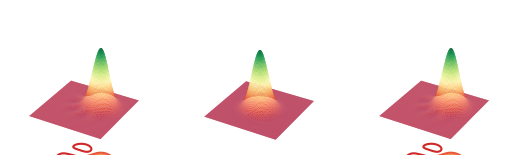

In [10]:
#@title  Visualizing results
from matplotlib import animation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def wigner(rho):
    """This code is a modified version of the 'iterative' method
    of the wigner function provided in QuTiP, which is released
    under the BSD license, with the following copyright notice:

    Copyright (C) 2011 and later, P.D. Nation, J.R. Johansson,
    A.J.G. Pitchford, C. Granade, and A.L. Grimsmo.

    All rights reserved."""
    import copy

    # Domain parameter for Wigner function plots
    l = 5.0
    cutoff = rho.shape[0]

    # Creates 2D grid for Wigner function plots
    x = np.linspace(-l, l, 100)
    p = np.linspace(-l, l, 100)

    Q, P = np.meshgrid(x, p)
    A = (Q + P * 1.0j) / (2 * np.sqrt(2 / 2))

    Wlist = np.array([np.zeros(np.shape(A), dtype=complex) for k in range(cutoff)])

    # Wigner function for |0><0|
    Wlist[0] = np.exp(-2.0 * np.abs(A) ** 2) / np.pi

    # W = rho(0,0)W(|0><0|)
    W = np.real(rho[0, 0]) * np.real(Wlist[0])

    for n in range(1, cutoff):
        Wlist[n] = (2.0 * A * Wlist[n - 1]) / np.sqrt(n)
        W += 2 * np.real(rho[0, n] * Wlist[n])

    for m in range(1, cutoff):
        temp = copy.copy(Wlist[m])
        # Wlist[m] = Wigner function for |m><m|
        Wlist[m] = (2 * np.conj(A) * temp - np.sqrt(m) * Wlist[m - 1]) / np.sqrt(m)

        # W += rho(m,m)W(|m><m|)
        W += np.real(rho[m, m] * Wlist[m])

        for n in range(m + 1, cutoff):
            temp2 = (2 * A * Wlist[n - 1] - np.sqrt(m) * temp) / np.sqrt(n)
            temp = copy.copy(Wlist[n])
            # Wlist[n] = Wigner function for |m><n|
            Wlist[n] = temp2

            # W += rho(m,n)W(|m><n|) + rho(n,m)W(|n><m|)
            W += 2 * np.real(rho[m, n] * Wlist[n])

    return Q, P, W / 2

rho_target = np.outer(target_statevec, target_statevec.conj())
rho_first_learnt = np.outer(first_step_state, first_step_state.conj())
rho_learnt = np.outer(learnt_state, learnt_state.conj())

fig1 = plt.figure()
ax1 = fig1.add_subplot(131, projection="3d")
X, P, W = wigner(rho_target)
ax1.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax1.contour(X, P, W, 10, cmap="RdYlGn", linestyles="solid", offset=-0.17)
ax1.set_axis_off()
ax2 = fig1.add_subplot(132, projection="3d")
X, P, W = wigner(rho_first_learnt)
ax2.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax2.contour(X, P, W, 10, cmap="RdYlGn", linestyles="solid", offset=-0.17)
ax2.set_axis_off()
ax3 = fig1.add_subplot(133, projection="3d")
X, P, W = wigner(rho_learnt)
ax3.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax3.contour(X, P, W, 10, cmap="RdYlGn", linestyles="solid", offset=-0.17)
ax3.set_axis_off()
fig1.show()

## Hong-Ou-Mandel effect
[Description](https://en.wikipedia.org/wiki/Hong%E2%80%93Ou%E2%80%93Mandel_effect) With a 50-50 beamsplitter $(\theta\approx\frac{\pi}{4})$, when two identical photons each enter an input port, they will always exit together in the same output mode. In other words, a Fock state of $|11\rangle$ can be transformed to either $|02\rangle$ or $|20\rangle$, regardless of the value of $\phi$.

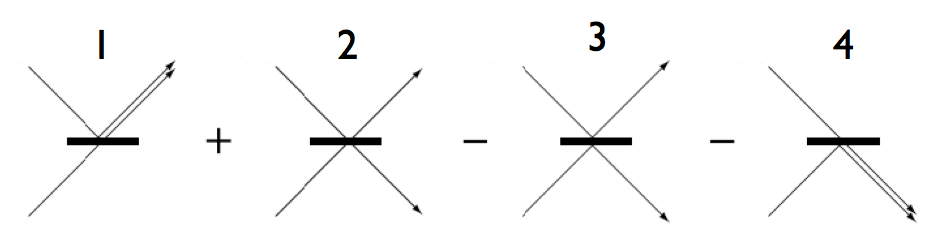

#### C.6 Demonstrating the Hong-Ou-Mandel effect

In [11]:
# initialize engine and program objects
eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": 7,"prepare_fock_state":[1,0],"prepare_fock_state":[1,1]})
circuit = sf.Program(2)

tf_theta = tf.Variable(tf.random.normal(shape=[], stddev=0.001))
tf_phi = tf.Variable(tf.random.normal(shape=[], stddev=0.001))

theta, phi = circuit.params("theta", "phi")

# Define circuit
with circuit.context as q:
    Fock(1) | q[0]
    Fock(1) | q[1]
    BSgate(theta, phi) | (q[0],q[1])

# Define parameters for optimization
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
steps = 50
best_prob = 0

# Start optimization
for step in range(steps):

    # reset the engine if it has already been executed
    if eng.run_progs:
        eng.reset()

    with tf.GradientTape() as tape:
        # execute the engine
        results = eng.run(circuit, args={"theta": tf_theta, "phi": tf_phi})
        # get the probability of fock state |1>
        # print(results.state.is_pure)
        prob = results.state.fock_prob([0,2])+results.state.fock_prob([2,0]) # sum of (0,2) and (2,0) Fock prob
        # prob = tf.abs(results.state.fidelity_coherent([0,1]))
        # negative sign to maximize prob
        loss = 1-tf.sqrt(prob)

    gradients = tape.gradient(loss, [tf_theta, tf_phi])
    opt.apply_gradients(zip(gradients, [tf_theta, tf_phi]))
    print("Prob at step {}: {}".format(step, prob))
    if prob > best_prob:
        best_prob = prob
        best_theta = tf_theta
        best_phi = tf_phi
        best_state = results.state

print(best_prob.numpy(),best_theta.numpy(),best_phi.numpy())
# sf.plot.generate_fock_chart(best_state,[0,1],7)

Prob at step 0: 1.2503591051427065e-06
Prob at step 1: 0.039905451238155365
Prob at step 2: 0.1523631066083908
Prob at step 3: 0.3191019892692566
Prob at step 4: 0.512721836566925
Prob at step 5: 0.7016474604606628
Prob at step 6: 0.8566697239875793
Prob at step 7: 0.9576941728591919
Prob at step 8: 0.9985119104385376
Prob at step 9: 0.9873226881027222
Prob at step 10: 0.942290186882019
Prob at step 11: 0.8842023611068726
Prob at step 12: 0.8301084041595459
Prob at step 13: 0.7905367612838745
Prob at step 14: 0.7699708342552185
Prob at step 15: 0.768674373626709
Prob at step 16: 0.7843597531318665
Prob at step 17: 0.8132314682006836
Prob at step 18: 0.850573718547821
Prob at step 19: 0.8911992311477661
Prob at step 20: 0.9299696683883667
Prob at step 21: 0.9624270796775818
Prob at step 22: 0.9854369759559631
Prob at step 23: 0.9976498484611511
Prob at step 24: 0.9996172785758972
Prob at step 25: 0.9935001134872437
Prob at step 26: 0.9824496507644653
Prob at step 27: 0.9698659181594849


Here, it is confirmed that $\theta$ is optimized to $\pm \frac{\pi}{4}$, while $\phi$ is *optimized* to $\approx 0$ since we started with a normal distribution for $\phi$ centered around 0 with an small standard deviation.

Possible applications of the Hong-Ou-Mandel effect includes quantum chemical reactivity through coherent control and spectroscopic methods.